# AIM: extract statistical time-frequency features and store in dataframe

1. load preprocessed EEG data
2. compute TFRs and normalize
3. extract [mean, std, median, skew, kurt] of power over time per channel per frequency band

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in participants data
and excluding replication data

In [2]:
df_participants = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\df_participants.pkl')
print(f'all participants: {df_participants.shape}')
df_participants.sample(5)

all participants: (714, 12)


,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,diagnosis
725,sub-88027577,DISCOVERY,ADHD,UNKNOWN,NaN,7.60,0,1,1,True,True,ADHD
771,sub-88032973,DISCOVERY,MDD,UNKNOWN,NaN,47.56,0,1,1,True,True,MDD
464,sub-88012817,DISCOVERY,MDD,MDD,MDD-rTMS,33.83,1,1,1,True,True,MDD
1238,sub-88071005,DISCOVERY,MDD,UNKNOWN,NaN,39.78,0,1,1,True,True,MDD
1320,sub-88076941,DISCOVERY,MDD,UNKNOWN,NaN,42.53,0,1,1,True,True,MDD


### Creating montage and info object of MNE

In [3]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }

# channel groupings (left/mid/right)
l_frontal = ['F3', 'FC3']
m_frontal = ['Fz', 'FCz']
r_frontal = ['F4', 'FC4']
l_central = ['C3', 'CP3']
m_central = ['Cz', 'CPz']
r_central = ['C4', 'CP4']
l_posterior = ['P3', 'O1'] 
m_posterior = ['Pz', 'Oz'] 
r_posterior = ['P4', 'O2'] 
channel_groups = {
    'l_frontal': l_frontal,
    'm_frontal': m_frontal,
    'r_frontal': r_frontal,
    'l_central': l_central,
    'm_central': m_central,
    'r_central': r_central,
    'l_posterior': l_posterior,
    'm_posterior': m_posterior,
    'r_posterior': r_posterior
}
all_channels = l_frontal + m_frontal + r_frontal + l_central + m_central + r_central + l_posterior + m_posterior + r_posterior

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}
all_freqs = np.concatenate([delta, theta, alpha, beta, gamma])

## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


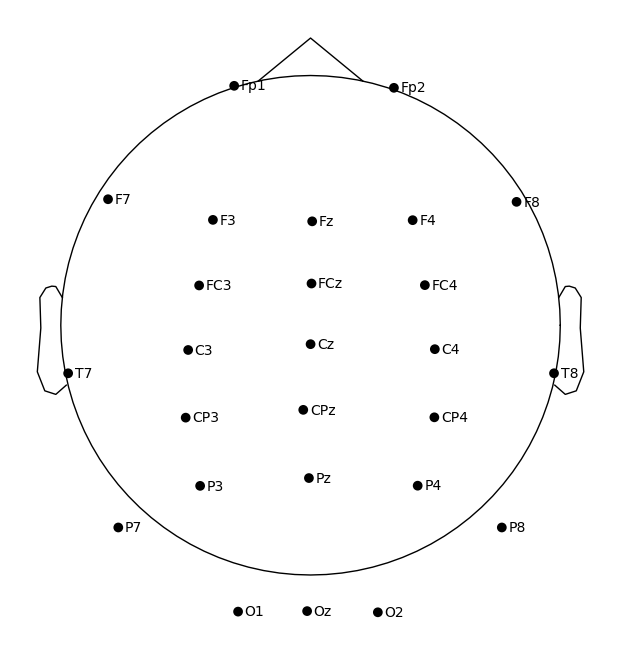

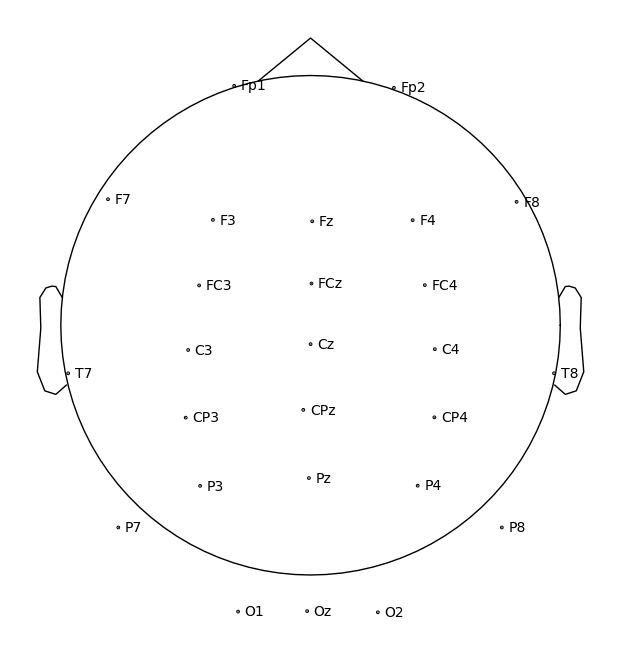

In [4]:
mne.viz.plot_montage(montage, scale_factor=0.5)

### Feature extraction and storing in df

In [36]:
import scipy

eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"
sample_ids = df_participants['participants_ID'].tolist() # list of participants to include
# sample_ids = ['sub-87966293', 'sub-87966337'] # for testing

df_ec_features = pd.DataFrame() # create empty dataframe to store EC features
df_eo_features = pd.DataFrame() # create empty dataframe to store EO features
df_ratio_features = pd.DataFrame() # create empty dataframe to store ratio features

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len([file for file in files if any(sample_id in file for sample_id in sample_ids) and '.npy' in file and 'ses-1' in file and 'BAD' not in file])

processed_IDs = [] # list to keep track of processed participants for ratio calculation
for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        if any(sample_id in file for sample_id in sample_ids): # filter participants to include
            if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                filepath = os.path.join(subdir, file) # path to eeg file

                # needs specific info object, because has one less channel than info created at the start of the notebook
                info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
                info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = mne.io.RawArray(np.squeeze(preprocessed_eeg['data']), info)

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 'EC'
                if 'EO' in file:
                    cond = 'EO'

                # determine age, gender, and diagnosis of participant corresponding to file
                age = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'age'].values[0]
                gender = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'gender'].values[0]
                diagnosis = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'diagnosis'].values[0]
                

                # add data to empty dictionary as a list with the same length as the number of epochs
                feature_dict = {}
                feature_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                feature_dict['age'] = [age] * epochs.get_data().shape[0]
                feature_dict['gender'] = [gender] * epochs.get_data().shape[0]
                feature_dict['diagnosis'] = [diagnosis] * epochs.get_data().shape[0]
                feature_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))

                
                # calculate TFR for all frequencies in freq bands and all channels in channel groups
                tfr_mt = tfr_multitaper(
                            epochs,
                            freqs=all_freqs,
                            n_cycles=(all_freqs / 2),
                            time_bandwidth=4,
                            use_fft=True,
                            return_itc=False,
                            average=False,
                            decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor (SEE 'decimation_and_freqs_param_selection.ipynb' IN 'background_notebooks')
                            n_jobs=-1,
                            picks=all_channels)
                
                # TFR normalization with the total average power per frequency
                tfr_mt_data = tfr_mt.data # shape [n_epochs, n_channels, n_freqs, n_times]
                tfr_mt_avg_freq = np.mean(tfr_mt_data, axis = 3) # average power over time per freq = shape [n_epochs, n_channels, n_freqs]
                total_tfr_mt_avg_freq = np.sum(tfr_mt_avg_freq, axis = 2) # sum avg power over freqs = shape [n_epochs, n_channels]
                tfr_mt_norm = tfr_mt_data / total_tfr_mt_avg_freq[:, :, np.newaxis, np.newaxis] # normalize by dividing the signal by the sum of avg power over freqs
                tfr_mt.data = tfr_mt_norm # store normalized data in tfr object

                # store TFR object for later ratio calculation
                if 'EC' in file:
                    EC_TFR_signal = tfr_mt
                if 'EO' in file:
                    EO_TFR_signal = tfr_mt
                
                # calculate features for each channel group and frequency band
                for group in channel_groups:
                    # select channels of interest
                    tfr_mt_group = tfr_mt.copy().pick(channel_groups[group]).data # shape [n_epochs, n_channels, n_freqs, n_times]
                    for band in bands:

                        # select frequencies of interest
                        start_index = np.where(tfr_mt.freqs == bands[band][0])[0][0]
                        end_index = np.where(tfr_mt.freqs == bands[band][-1])[0][0]
                        tfr_mt_band_group = tfr_mt_group[:, :, start_index:end_index, :] # shape [n_epochs, n_channels, n_freqs, n_times]

                        # # average signal over channels and frequencies to get one signal per channel group and frequency band
                        tfr_mt_avg = np.mean(tfr_mt_band_group, axis = (1, 2)) # average over channels and frequencies = shape [n_epochs, n_times]

                        # compute standard deviation in spectral spower per epoch per channel group per freq band
                        tfr_mt_std = np.std(tfr_mt_avg, axis=1) # shape [n_epochs]
                        # compute average spectral power per epoch per channel group per freq band
                        tfr_mt_mean = np.mean(tfr_mt_avg, axis=1) # shape [n_epochs]
                        # compute median spectral power per epoch per channel group per freq band
                        tfr_mt_mean_median = np.median(tfr_mt_avg, axis=1) # shape [n_epochs]
                        # compute skewness of spectral power per epoch per channel group per freq band
                        tfr_mt_skew = scipy.stats.skew(tfr_mt_avg, axis=1) # shape [n_epochs]
                        # compute kurtosis of spectral power per epoch per channel group per freq band
                        tfr_mt_kurt = scipy.stats.kurtosis(tfr_mt_avg, axis=1) # shape [n_epochs]

                        # add to dictionary
                        feature_dict[f'{cond}_{group}_{band}_std'] = tfr_mt_std # shape [n_epochs]
                        feature_dict[f'{cond}_{group}_{band}_mean'] = tfr_mt_mean # shape [n_epochs]
                        feature_dict[f'{cond}_{group}_{band}_median'] = tfr_mt_mean # shape [n_epochs]
                        feature_dict[f'{cond}_{group}_{band}_skew'] = tfr_mt_skew # shape [n_epochs]
                        feature_dict[f'{cond}_{group}_{band}_kurt'] = tfr_mt_kurt # shape [n_epochs]

                # If both EC and EO have been processed from the same participant, calculate ratio features. This only works if you only select 1 session per participant
                if file.split('_')[0] in processed_IDs:
                    ratio_feature_dict = {}
                    ratio_feature_dict['ID'] = feature_dict['ID']
                    ratio_feature_dict['age'] = feature_dict['age']
                    ratio_feature_dict['gender'] = feature_dict['gender']
                    ratio_feature_dict['diagnosis'] = feature_dict['diagnosis']
                    ratio_feature_dict['epoch'] = feature_dict['epoch']

                    # Check if the number of epochs of both arrays are the same
                    if EC_TFR_signal.data.shape[0] != EO_TFR_signal.data.shape[0]:
                        # If not, find the minimum size
                        min_size = min(EC_TFR_signal.data.shape[0], EO_TFR_signal.data.shape[0])

                        # Resize the arrays to the minimum size
                        EC_TFR_signal.data = EC_TFR_signal.data[:min_size]
                        EO_TFR_signal.data = EO_TFR_signal.data[:min_size]
                    # calculate ratio of EC and EO signals
                    ratio_TFR_signal = EC_TFR_signal.copy() # copy info containing channels and frequencies from EC TFR object to new TFR object for the ratio features
                    ratio_TFR_signal.data = np.divide(EC_TFR_signal.data, EO_TFR_signal.data) # shape [n_epochs, n_channels, n_freqs, n_times]
                    
                    # calculate features for each channel group and frequency band
                    for group in channel_groups:
                        # select channels of interest
                        tfr_mt_group = ratio_TFR_signal.copy().pick(channel_groups[group]).data # shape [n_epochs, n_channels, n_freqs, n_times]
                        for band in bands:

                            # select frequencies of interest
                            start_index = np.where(tfr_mt.freqs == bands[band][0])[0][0]
                            end_index = np.where(tfr_mt.freqs == bands[band][-1])[0][0]
                            tfr_mt_band_group = tfr_mt_group[:, :, start_index:end_index, :] # shape [n_epochs, n_channels, n_freqs, n_times]

                            # average signal over channels and frequencies to get one signal per channel group and frequency band
                            tfr_mt_avg = np.mean(tfr_mt_band_group, axis = (1, 2)) # average over channels and frequencies = shape [n_epochs, n_times]

                            ratio_feature_dict[f'ratio_{group}_{band}_std'] = np.std(tfr_mt_avg, axis=1) # calculate stdev over time = shape [n_epochs]
                            ratio_feature_dict[f'ratio_{group}_{band}_mean'] = np.mean(tfr_mt_avg, axis=1) # calculate mean over time = shape [n_epochs]
                            ratio_feature_dict[f'ratio_{group}_{band}_median'] = np.median(tfr_mt_avg, axis=1) # calculate median over time = shape [n_epochs]
                            ratio_feature_dict[f'ratio_{group}_{band}_skew'] = scipy.stats.skew(tfr_mt_avg, axis=1) # calculate skew over time = shape [n_epochs]
                            ratio_feature_dict[f'ratio_{group}_{band}_kurt'] = scipy.stats.kurtosis(tfr_mt_avg, axis=1) # calculate kurt over time = shape [n_epochs]
                    
                    df_ratio_features = pd.concat([df_ratio_features, pd.DataFrame(ratio_feature_dict)], ignore_index = True)
                    
                # add to dataframe
                if cond == 'EC':
                    df_ec_features = pd.concat([df_ec_features, pd.DataFrame(feature_dict)], ignore_index = True)
                if cond == 'EO':
                    df_eo_features = pd.concat([df_eo_features, pd.DataFrame(feature_dict)], ignore_index = True)

                processed_IDs.append(file.split('_')[0]) # add participant to list of processed participants

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1

# merge EO and EC dataframes
print('\n')
print('Missing diagnoses in EO instances:', df_eo_features['diagnosis'].isnull().sum()) # sanity check
print('Missing diagnoses in EC instances:', df_ec_features['diagnosis'].isnull().sum()) # sanity check
print('Missing diagnoses in ratio instances:', df_ratio_features['diagnosis'].isnull().sum()) # sanity check
# merge EO, EC and ratio dataframes
df_features = pd.merge(df_eo_features, pd.merge(df_ec_features.drop(columns=['age', 'gender']), df_ratio_features.drop(columns=['age', 'gender']),  how='outer', on=['ID', 'epoch', 'diagnosis']),  how='outer', on=['ID', 'epoch', 'diagnosis'])
del df_ec_features, df_eo_features, df_ratio_features # remove dataframes to free up memory                
print(f'\n{df_features.shape = }')
df_features.sample(3)

Progress: 1314/1314 files processed.

Missing diagnoses in EO instances: 0
Missing diagnoses in EC instances: 0
Missing diagnoses in ratio instances: 0

df_features.shape = (7932, 680)


,ID,age,gender,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,...,ratio_r_posterior_beta_std,ratio_r_posterior_beta_mean,ratio_r_posterior_beta_median,ratio_r_posterior_beta_skew,ratio_r_posterior_beta_kurt,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median,ratio_r_posterior_gamma_skew,ratio_r_posterior_gamma_kurt
1211,sub-87976817,19.17,0.0,HEALTHY,12,0.114357,0.102421,0.102421,2.477243,6.646098,...,1.465911,2.293035,1.945299,2.273024,8.231296,1.011542,2.518405,2.344977,1.169695,1.904055
3966,sub-88041665,43.89,0.0,MDD,7,0.029358,0.041653,0.041653,1.244972,1.660758,...,2.589958,2.402784,1.648009,3.310128,15.204674,0.884333,1.109341,0.828489,2.665354,12.208442
5127,sub-88052013,47.21,0.0,MDD,4,0.050293,0.067252,0.067252,0.891801,0.016905,...,4.012377,2.904164,1.521348,3.225689,13.064603,0.431131,0.822889,0.752809,2.303297,10.374650


In [37]:
# plot distribution of each feature as a histogram and save to pdf
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

numeric_cols = [col for col in df_features.columns if 'EC' in col or 'EO' in col or 'ratio' in col]
# Create a PdfPages object
with PdfPages('test_standardized_feature_distributions.pdf') as pdf:
    # Iterate over numeric columns
    for i in range(0, len(numeric_cols), 5):
        # Create a new figure for each set of 5 features
        plt.figure(figsize=(10, 10))
        
        for j in range(5):
            if i+j < len(numeric_cols):
                plt.subplot(5, 1, j+1)
                sns.histplot(df_features[numeric_cols[i+j]], kde=False)
                plt.title(numeric_cols[i+j])
        
        # Tight layout often produces nice results
        # but requires the title to be spaced accordingly
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        
        # Save the current figure to the pdf
        pdf.savefig()
        plt.close()

In [38]:
# check missing values
df_features.isnull().sum()

ID                                  0
age                               169
gender                             13
diagnosis                           0
epoch                               0
                                 ... 
ratio_r_posterior_gamma_std        97
ratio_r_posterior_gamma_mean       97
ratio_r_posterior_gamma_median     97
ratio_r_posterior_gamma_skew       97
ratio_r_posterior_gamma_kurt       97
Length: 680, dtype: int64

In [39]:
# save dataframe to pickle
df_features.to_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_stat_features.pkl')